In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 20})

def process_and_plot(ax, file_paths, multipliers, shift_days=0, 
                     trace_color='grey', trace_alpha=0.5, 
                     line_color='b', line_alpha=0.5, subplot_title=""):
    """
    Reads two CSV files, applies the given multipliers to DVT,
    interpolates them onto a unified time axis, and then plots:
      1) The individual (grey) traces, each shifted in time by shift_days
      2) The weighted Δv/v curve (in blue).
      3) The bar plot of filtered events on a secondary y-axis.
    """
    # Define the path and time range inside the function
    filtered_events_path = 'filtered_events_per_day_lat_44.csv'
    start_date = pd.to_datetime("2015-01-01")
    end_date = pd.to_datetime("2021-01-01")

    # Significant event dates
    Tdates = ['2015-06-24 22:25:29.343674','2015-10-21 07:10:22.988772','2016-01-10 21:12:28.836671','2016-02-27 12:03:06.102124','2016-06-04 14:36:16.085195',
      '2016-06-04 14:37:36.094455','2016-08-05 16:32:06.889686','2016-08-14 00:35:30.246556','2016-08-14 14:38:36.101401','2016-08-20 22:07:09.216344',
      '2016-09-01 15:43:16.550527','2016-09-17 02:04:20.863526','2016-09-17 02:08:10.890149','2016-09-24 18:19:27.635143','2016-09-25 03:22:01.402940',
      '2016-09-25 03:24:51.422618','2016-10-02 12:07:35.052668','2016-11-18 05:22:02.236370','2017-07-29 04:03:41.692326','2017-09-06 10:28:44.366246',
      '2017-09-06 13:01:05.424239','2017-09-06 13:13:25.509897','2017-09-06 13:15:45.526103','2017-09-06 13:19:15.550411','2017-09-06 13:48:05.750666',
      '2017-09-06 13:55:55.805070','2017-09-06 13:58:15.821276','2017-09-06 14:06:35.879153','2017-09-06 14:10:55.909249','2017-09-06 14:31:06.049311',
      '2017-09-06 14:47:16.161593','2017-09-06 15:14:26.350272','2017-09-06 15:32:06.472971','2017-09-06 16:52:17.029749','2017-09-06 17:02:57.103831',
      '2017-09-06 17:04:37.115407','2017-09-06 17:06:47.130455','2017-09-06 17:37:27.343443','2018-01-03 15:22:06.403519','2018-02-10 14:43:16.133812',
      '2018-03-13 15:48:13.211856','2018-06-26 12:51:25.357102','2018-06-26 13:01:05.424239','2018-09-19 07:27:03.104526','2019-05-11 05:18:53.169843',
      '2019-07-11 03:20:01.777251','2019-07-11 03:32:31.888329','2019-07-11 03:46:02.008294','2020-05-08 09:41:54.040977','2020-07-09 09:30:43.963422']

    datetime_objects = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f') for date in Tdates]

    # Load and process filtered events
    filtered_events = pd.read_csv(filtered_events_path, index_col=0, parse_dates=True)

    # Load, process, and interpolate data
    dataframes = []
    for path, multiplier in zip(file_paths, multipliers):
        df = pd.read_csv(path)
        df['DVT'] *= multiplier
        df['T'] = pd.to_datetime(df['T'])
        df.set_index('T', inplace=True)
        dataframes.append(df)

    unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))
    interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

    # Shift and plot grey traces
    for df in interpolated_dfs:
        shifted_df = df.copy()
        shifted_df.index += pd.DateOffset(days=shift_days)
        ax.plot(shifted_df.index, shifted_df['DVT'], color=trace_color, alpha=trace_alpha)

    # Calculate weighted Δv/v
    CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)
    weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean
    weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
    weighted_dvv_df.index += pd.DateOffset(days=shift_days)

    # Plot weighted Δv/v
    ax.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 
            color=line_color, alpha=line_alpha)
    
    for dt in datetime_objects:
        ax.axvline(x=dt, color='red', linestyle='--')

    # Add secondary y-axis for bar plot
    ax2 = ax.twinx()
    ax2.bar(filtered_events.index, filtered_events['Number of Events'], 
            width=1, edgecolor='black', alpha=0.6)
    ax2.set_ylabel('Number of Events', fontsize=16)
    ax2.set_ylim([0, filtered_events['Number of Events'].max() * 1.1])

    # Set titles, labels, and grid
    ax.set_title(subplot_title, fontsize=18)
    ax.set_xlabel('Date')
    ax.set_ylabel('Weighted Δv/v %')
    ax.set_xlim([start_date, end_date])
    
    # Increase the number of y-axis gridlines
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Change as needed
    #ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(0.05))

    # Add gridlines
    #ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True)

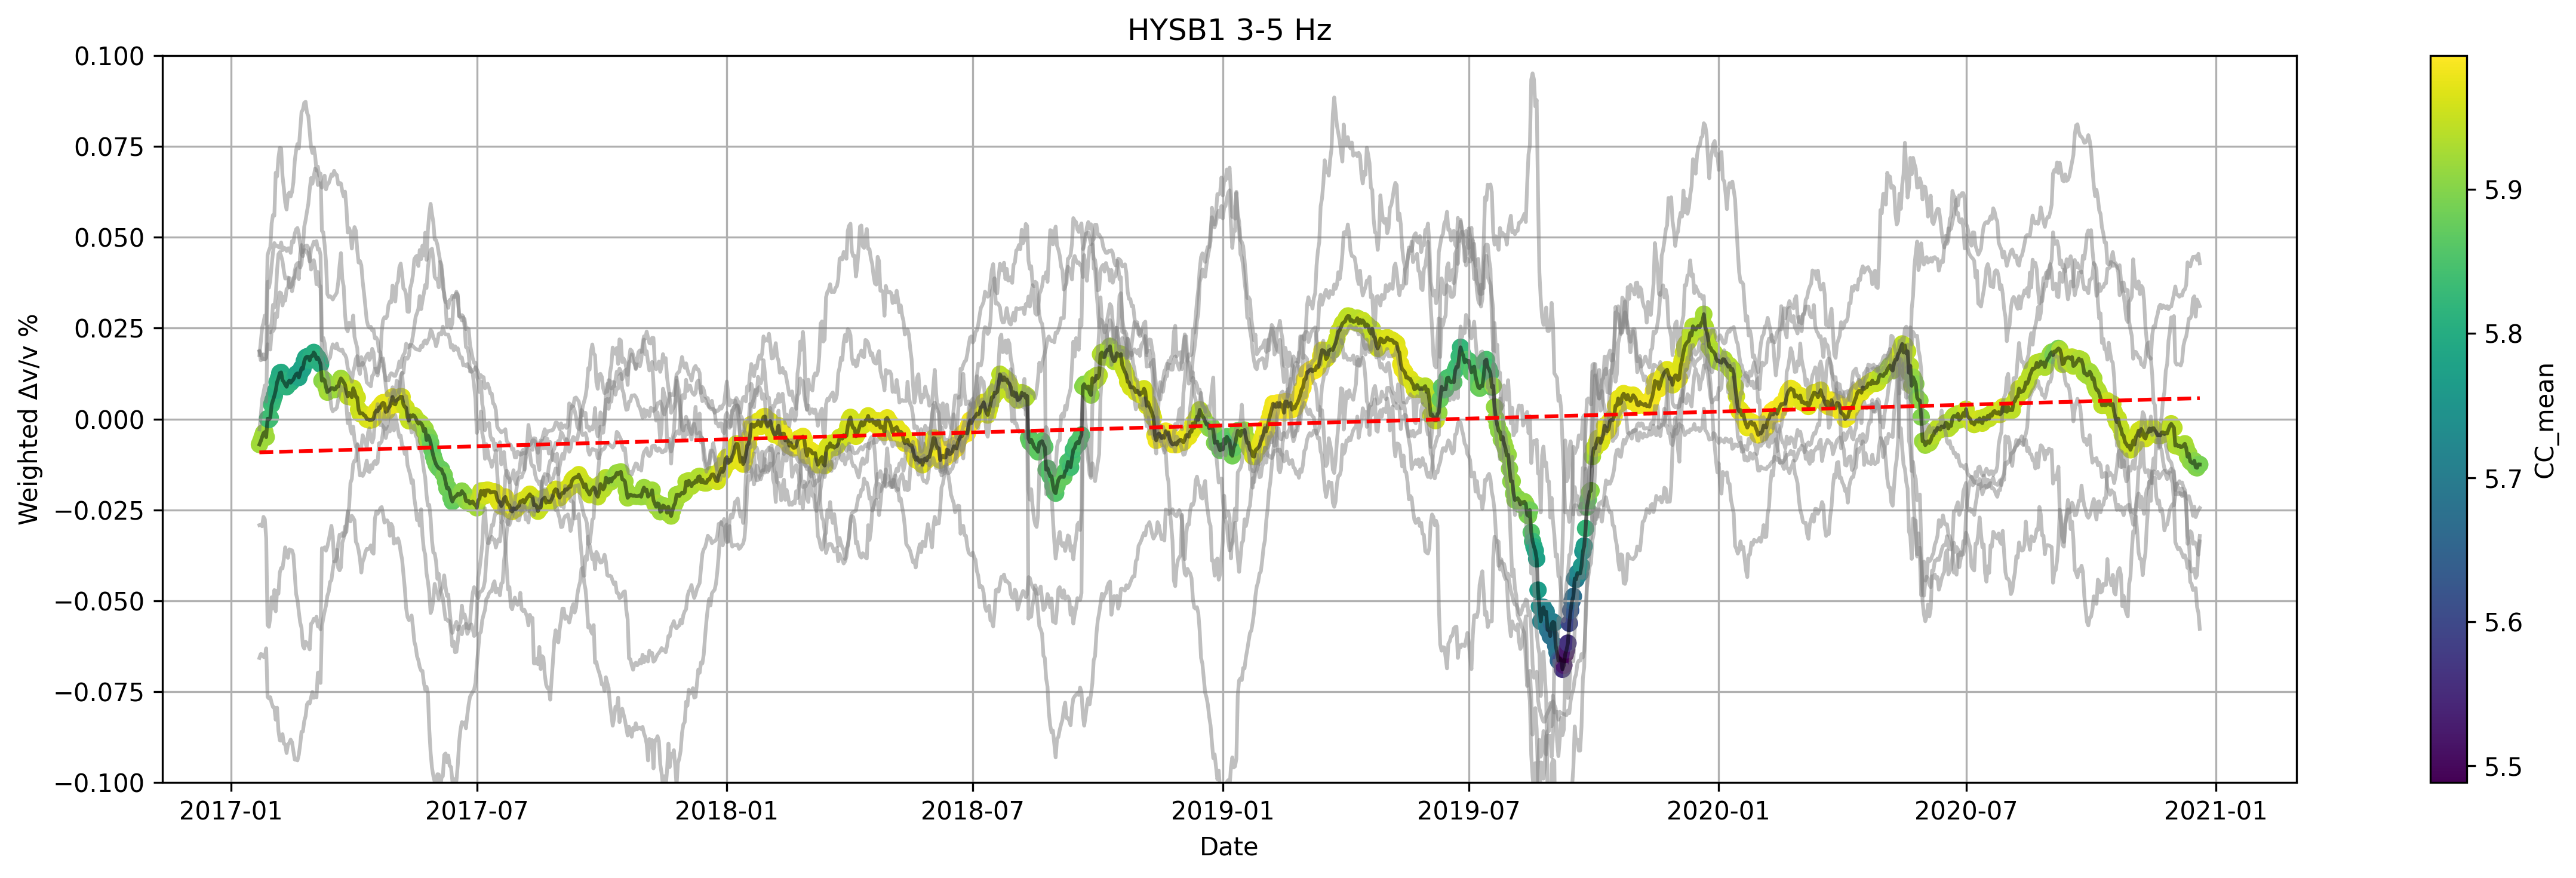

In [9]:
# import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the paths to your CSV files
file_paths = [
    'HYSB1_long_ZE_positive_3-5.csv',
    'HYSB1_long_ZE_negative_3-5.csv',
    'HYSB1_long_ZN_positive_3-5.csv',
    'HYSB1_long_ZN_negative_3-5.csv',
    'HYSB1_long_NE_negative_3-5.csv',
    'HYSB1_long_NE_positive_3-5.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1,1,1,1,1,1]

# Read and process dataframes
dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    dataframes.append(df)

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Shift the grey individual timeseries by 20 days and plot them
plt.figure(figsize=(16, 5), dpi=300)
for df in interpolated_dfs:
    shifted_df = df.copy()
    shifted_df.index = shifted_df.index + pd.DateOffset(days=0)
    plt.plot(shifted_df.index, shifted_df['DVT'], color='grey', alpha=0.5)

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=0)

# Plotting the weighted Δv/v time series with color-coded CC_mean
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')

# Adding a trend line
cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])
index_as_int = cleaned_df.index.astype(np.int64)
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')

# Add labels and legend
plt.xlabel('Date')
plt.ylim([-0.1, 0.1])
plt.title('HYSB1 3-5 Hz')
plt.ylabel('Weighted Δv/v %')
plt.grid(True)
plt.tight_layout()
plt.show()

HYSB1_35 = weighted_dvv_df


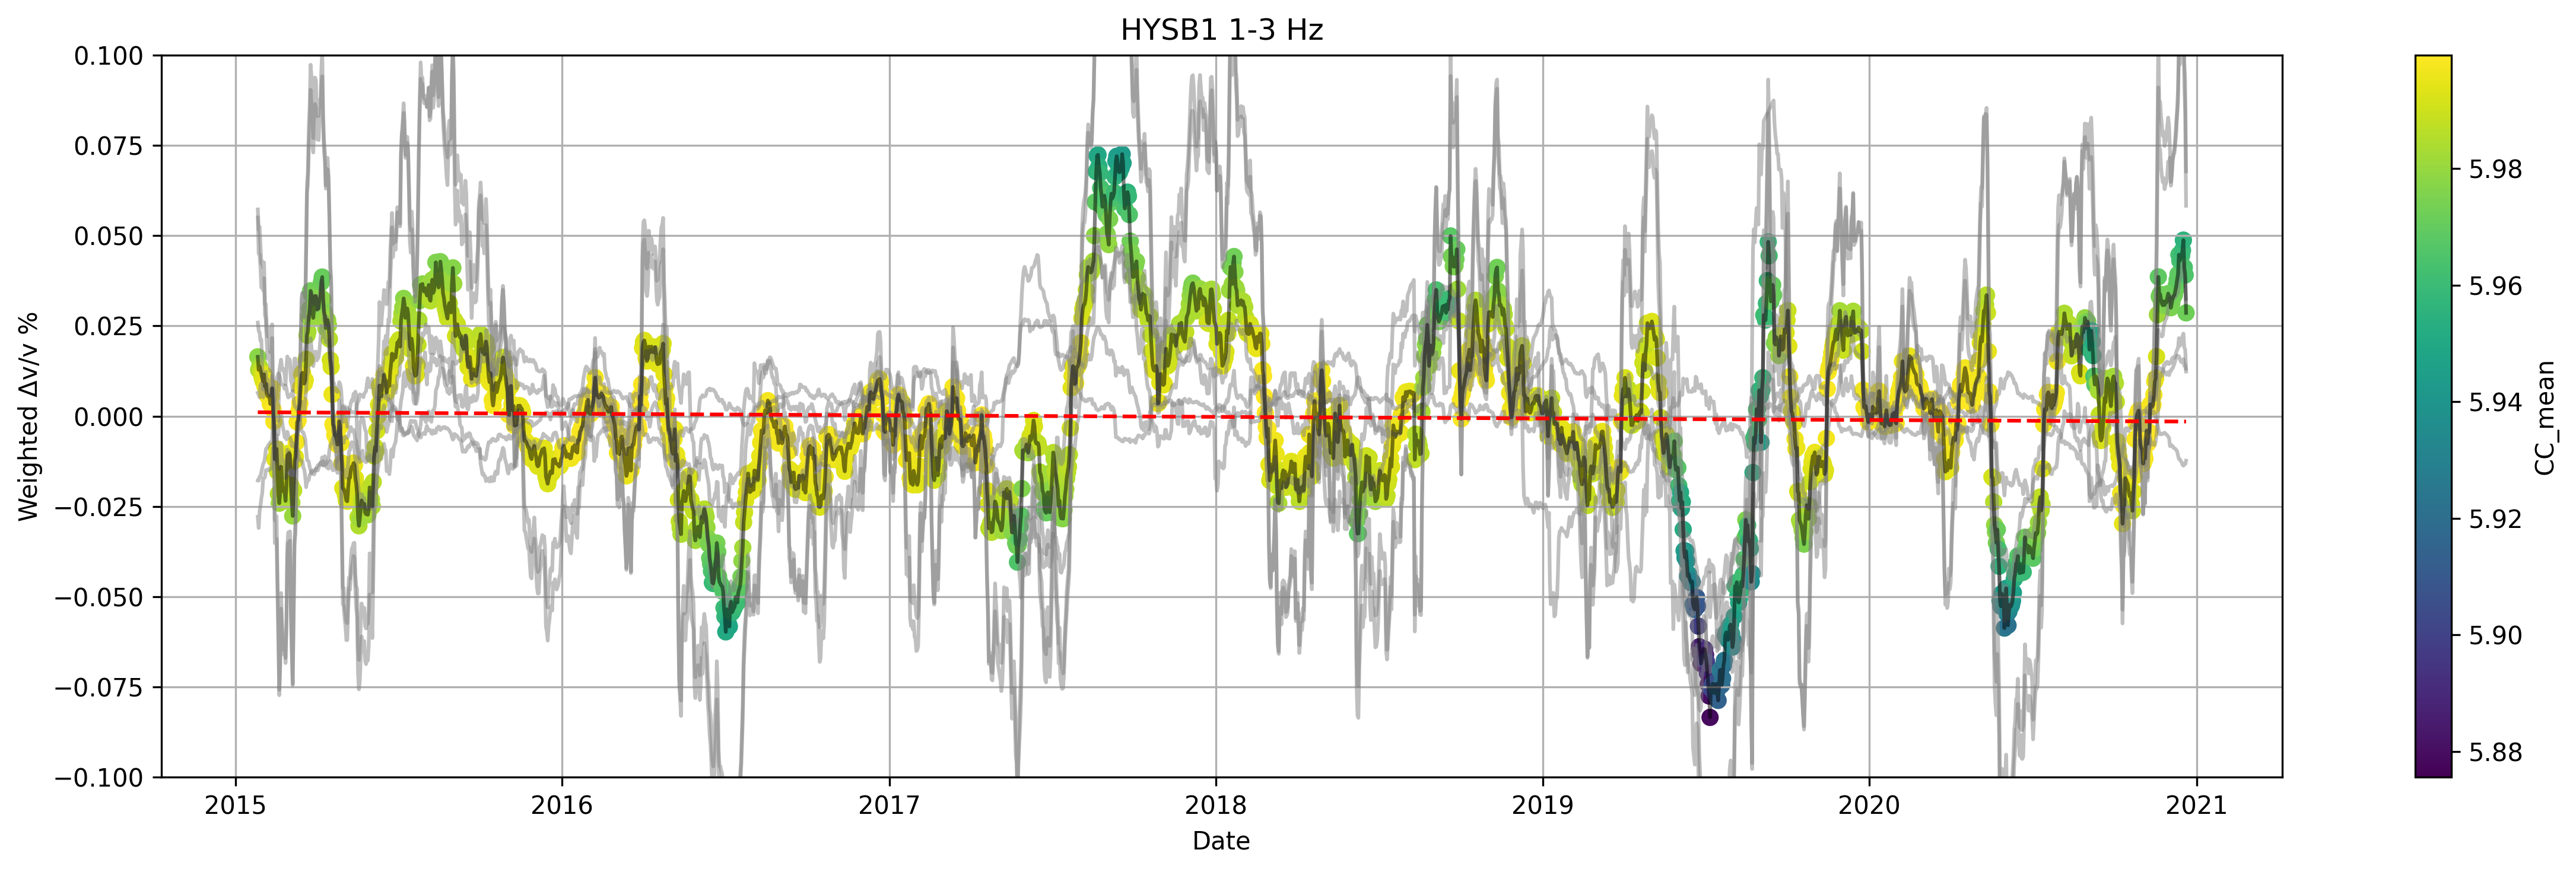

In [10]:
# import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the paths to your CSV files
file_paths = [
    'Data/HYSB1_late_ZE_positive_1.0-3.0.csv',
    'Data/HYSB1_late_ZE_negative_1.0-3.0.csv',
    'Data/HYSB1_late_ZN_positive_1.0-3.0.csv',
    'Data/HYSB1_late_ZN_negative_1.0-3.0.csv',
    'Data/HYSB1_late_NE_positive_1.0-3.0.csv',
    'Data/HYSB1_late_NE_negative_1.0-3.0.csv'
]

# Predefined array with multipliers (-1 or +1)
multipliers = [-1, 1,1,1,1,1]

# Read and process dataframes
dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    dataframes.append(df)

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Shift the grey individual timeseries by 20 days and plot them
plt.figure(figsize=(16, 5), dpi=300)
for df in interpolated_dfs:
    shifted_df = df.copy()
    shifted_df.index = shifted_df.index + pd.DateOffset(days=0)
    plt.plot(shifted_df.index, shifted_df['DVT'], color='grey', alpha=0.5)

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=0)

# Plotting the weighted Δv/v time series with color-coded CC_mean
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')

# Adding a trend line
cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])
index_as_int = cleaned_df.index.astype(np.int64)
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')
# Add labels and legend
plt.xlabel('Date')
plt.ylim([-0.1, 0.1])
plt.title('HYSB1 1-3 Hz')
plt.ylabel('Weighted Δv/v %')
plt.grid(True)
plt.tight_layout()
plt.show()

HYSB1_13 = weighted_dvv_df


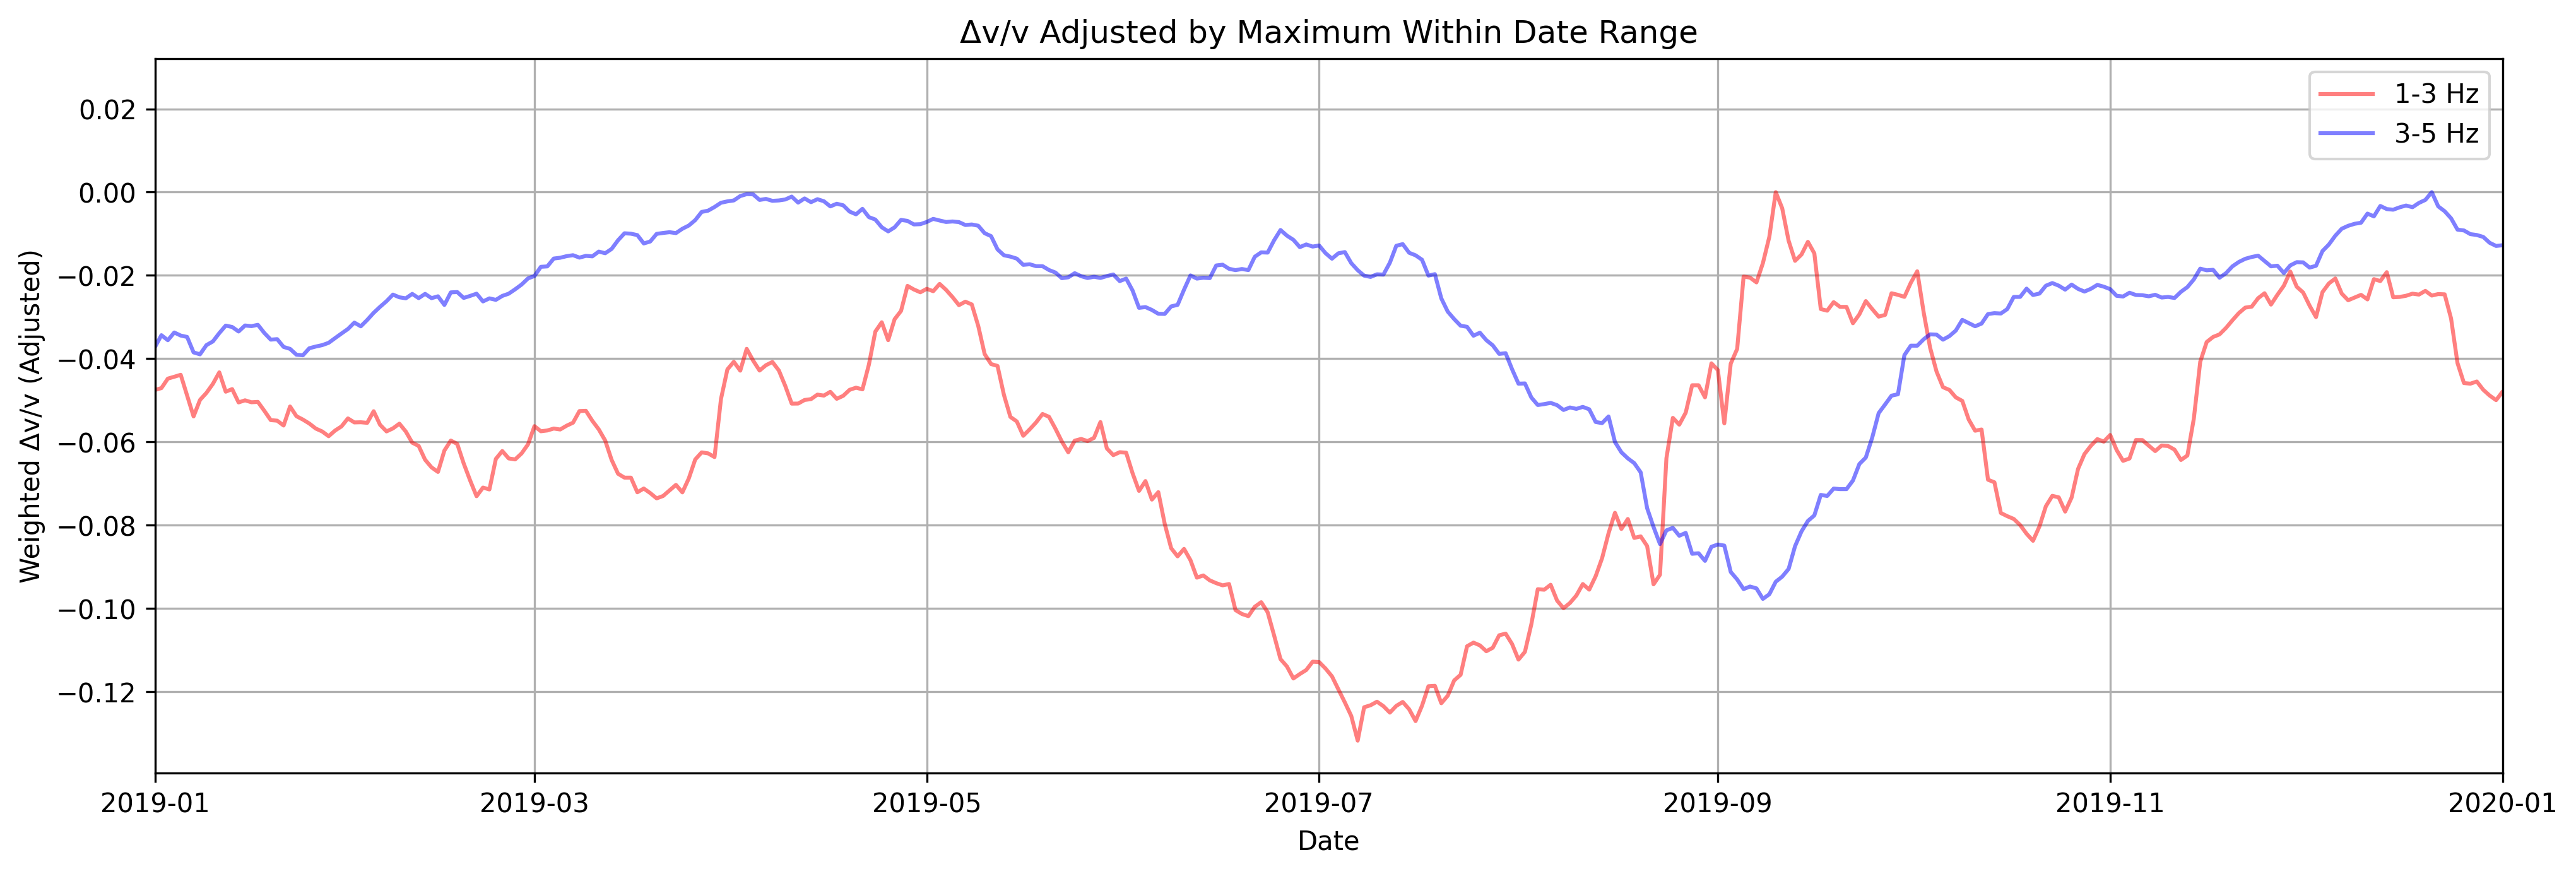

In [11]:
plt.figure(figsize=(16, 5), dpi=300)
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2020-01-01")
# Filter the data for the specified date range
HYSB1_13_filtered = HYSB1_13[(HYSB1_13.index >= start_date) & (HYSB1_13.index <= end_date)]
HYSB1_35_filtered = HYSB1_35[(HYSB1_35.index >= start_date) & (HYSB1_35.index <= end_date)]

# Find the maximum within the filtered date range
max_13 = max(HYSB1_13_filtered['Weighted Δv/v'])
max_35 = max(HYSB1_35_filtered['Weighted Δv/v'])

# Subtract the maximum values and plot
plt.plot(HYSB1_13.index, HYSB1_13['Weighted Δv/v'] - max_13, 'r-', alpha=0.5, label='1-3 Hz')
plt.plot(HYSB1_35.index, HYSB1_35['Weighted Δv/v'] - max_35, 'b-', alpha=0.5, label='3-5 Hz')

# Set the date range for the x-axis
plt.xlim([start_date, end_date])

# Add grid and legend for clarity
plt.grid(True)
plt.legend()
plt.title("Δv/v Adjusted by Maximum Within Date Range")
plt.xlabel("Date")
plt.ylabel("Weighted Δv/v (Adjusted)")

plt.show()


In [5]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the triangle function
def triangle_function(x, a, b, c):
    return a * np.maximum(-0.3, 1 - np.abs(x - b) / c)

# Filter data for May to September 2019
start_fit_date = pd.to_datetime("2019-04-15")
end_fit_date = pd.to_datetime("2019-10-15")
filtered_data = HYSB1_13[(HYSB1_13.index >= start_fit_date) & (HYSB1_13.index <= end_fit_date)]

# Extract time (as ordinal for fitting) and Δv/v values
x_data = filtered_data.index.map(lambda x: x.toordinal())  # Convert to ordinal for fitting
y_data = filtered_data['Weighted Δv/v'].values

# Perform curve fitting
initial_guess = [-0.1,np.mean(x_data), 30]  # Initial guess for [amplitude, center, width]
params, _ = curve_fit(triangle_function, x_data, y_data, p0=initial_guess)

# Generate triangle fit for plotting
x_fit = np.linspace(x_data.min(), x_data.max(), 1000)
y_fit = triangle_function(x_fit, *params)

# Convert x_fit back to datetime for plotting
x_fit_dates = [pd.Timestamp.fromordinal(int(x)) for x in x_fit]




In [6]:
start_fit_date = pd.to_datetime("2019-04-15")
end_fit_date = pd.to_datetime("2020-01-01")
filtered_data = HYSB1_35[(HYSB1_35.index >= start_fit_date) & (HYSB1_35.index <= end_fit_date)]

# Extract time (as ordinal for fitting) and Δv/v values
x_data = filtered_data.index.map(lambda x: x.toordinal())  # Convert to ordinal for fitting
y_data = filtered_data['Weighted Δv/v'].values

# Perform curve fitting
initial_guess = [-0.1,np.mean(x_data), 30]  # Initial guess for [amplitude, center, width]
params2, _ = curve_fit(triangle_function, x_data, y_data, p0=initial_guess)

# Generate triangle fit for plotting
x_fit2 = np.linspace(x_data.min(), x_data.max(), 1000)
y_fit2 = triangle_function(x_fit2, *params2)

# Convert x_fit back to datetime for plotting
x_fit_dates2 = [pd.Timestamp.fromordinal(int(x)) for x in x_fit2]


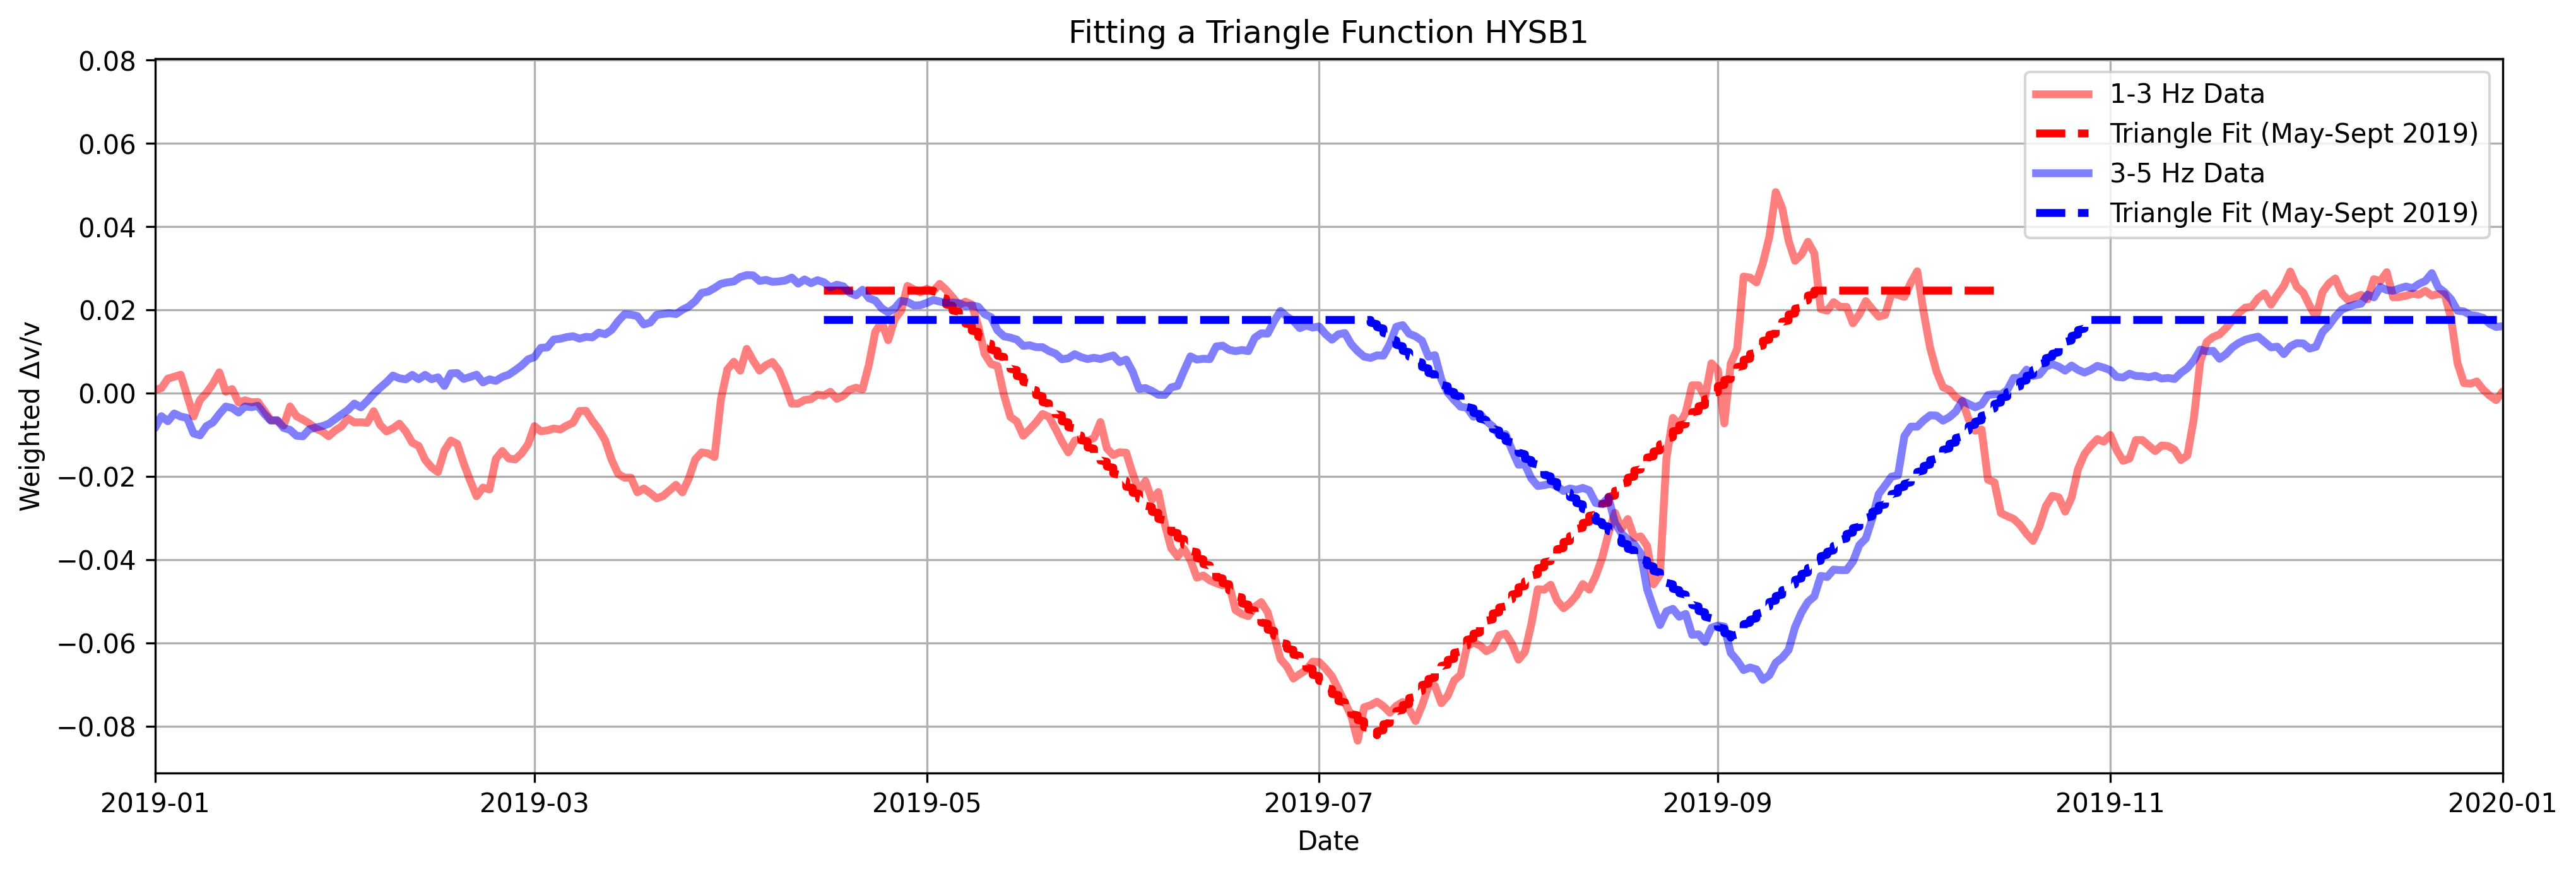

In [12]:
# Plot the results
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(HYSB1_13.index, HYSB1_13['Weighted Δv/v'], 'r-', alpha=0.5, label='1-3 Hz Data',linewidth=3)
plt.plot(x_fit_dates, y_fit, 'r--', label='Triangle Fit (May-Sept 2019)', linewidth=3)
plt.plot(HYSB1_35.index, HYSB1_35['Weighted Δv/v'], 'b-', alpha=0.5, label='3-5 Hz Data',linewidth=3)
plt.plot(x_fit_dates2, y_fit2, 'b--', label='Triangle Fit (May-Sept 2019)', linewidth=3)
plt.xlim([pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01")])
plt.grid(True)
plt.legend()
plt.title("Fitting a Triangle Function HYSB1")
plt.xlabel("Date")
plt.ylabel("Weighted Δv/v")
plt.show()

## HYS14 2019 event

## HYSB1 2022 event